## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


Methodology
We will adopt the OSEMiN data science workflow, which involves:

-Obtain (import the data)
-Scrub (clean the data, deal with missing values and data types)
-Explore (answer descriptives questions using EDA)
-Model (build our predictive model)
-Interpret (comment on our model and findings)

# Column Names and descriptions for Kings County Data Set
id - unique identified for a house

dateDate - house was sold

pricePrice -  is prediction target

bedroomsNumber -  of Bedrooms/House
bathroomsNumber -  of bathrooms/bedrooms
sqft_livingsquare -  footage of the home
sqft_lotsquare -  footage of the lot
floorsTotal -  floors (levels) in house
waterfront - House which has a view to a waterfront
view - Has been viewed
condition - How good the condition is ( Overall )
grade - overall grade given to the housing unit, based on King County grading system
sqft_above - square footage of house apart from basement
sqft_basement** - square footage of the basement
yr_built** - Built Year
yr_renovated** - Year when house was renovated
zipcode** - zip
lat** - Latitude coordinate
long** - Longitude coordinate
sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors


# Import packages

In [1]:
# Import libraries

import pandas as pd
import numpy as np

from itertools import combinations

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')

from pathlib import Path
import pickle
import json


from statsmodels.formula.api import ols
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Import and examine data

In [2]:
data = pd.read_csv('kc_house_data.csv')
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


# Cleaning dataset

Let's see how many unique values has each one of the columns.

In [4]:
# Function that will find the number of unique values and tell us if it's high or low.
def find_number_unique_values(df):
    low_unique_values=[]
    high_unique_values=[]
    for i in df.columns:
        if df[i].nunique()<100:
            print(f" {i} - low number of unique values") 
        else:
             print(f" {i} - hig number of unique values") 
        
        #print(f" There are {df[i].nunique()} {i} uniques values.")

In [5]:
find_number_unique_values(data)

 id - hig number of unique values
 date - hig number of unique values
 price - hig number of unique values
 bedrooms - low number of unique values
 bathrooms - low number of unique values
 sqft_living - hig number of unique values
 sqft_lot - hig number of unique values
 floors - low number of unique values
 waterfront - low number of unique values
 view - low number of unique values
 condition - low number of unique values
 grade - low number of unique values
 sqft_above - hig number of unique values
 sqft_basement - hig number of unique values
 yr_built - hig number of unique values
 yr_renovated - low number of unique values
 zipcode - low number of unique values
 lat - hig number of unique values
 long - hig number of unique values
 sqft_living15 - hig number of unique values
 sqft_lot15 - hig number of unique values


# We're going to examine separately columns with high number of unique values and low numbers of unique values.

1. High numbers of values:

id, date, price, sqft_living, sqft_lot, sqft_above, sqft_basement, yr_built, lat, long, sqft_living15, sqft_lot15.

2. Low number of values:

bedrooms, bathrooms, floors, waterfront, view, condition, grade, yr_renovated, zipcode.

## Remove outliers.

I found this function here: https://github.com/nadinezab/kc-house-prices-prediction/blob/master/kc-house-prices.ipynb

In [6]:
# Define function to remove outliers
def remove_outliers(df):
    '''removes entries with z-score above 3 for specific columns'''
    variables = ['bedrooms', 'sqft_living', 'sqft_lot', 'condition', 'grade']
    
    for variable in variables:
        df = df[np.abs(df[variable]-df[variable].mean()) <= (3*df[variable].std())]
        
    return df

In [7]:
df = remove_outliers(data)
len(df)

20594

# id column


#Let's see how many unique id-s we have in the data set.

In [8]:
print(f" There are {df['id'].nunique()} id_column uniques values.")

 There are 20423 id_column uniques values.


We have a few duplicate id-s now let's see if there are duplicate rows.

In [9]:
duplicateRowsData = df[df.duplicated()]
print(duplicateRowsData)

Empty DataFrame
Columns: [id, date, price, bedrooms, bathrooms, sqft_living, sqft_lot, floors, waterfront, view, condition, grade, sqft_above, sqft_basement, yr_built, yr_renovated, zipcode, lat, long, sqft_living15, sqft_lot15]
Index: []

[0 rows x 21 columns]


we don't have duplicated rows. 

In [10]:
duplicateIdData = df[df.duplicated(['id'])]
print(duplicateIdData)

               id        date     price  bedrooms  bathrooms  sqft_living  \
94     6021501535  12/23/2014  700000.0         3       1.50         1580   
325    7520000520   3/11/2015  240500.0         2       1.00         1240   
346    3969300030  12/29/2014  239900.0         4       1.00         1000   
372    2231500030   3/24/2015  530000.0         4       2.25         2180   
718    8820903380    1/2/2015  730000.0         6       2.25         2660   
...           ...         ...       ...       ...        ...          ...   
20165  7853400250   2/19/2015  645000.0         4       3.50         2910   
20597  2724049222   12/1/2014  220000.0         2       2.50         1000   
20654  8564860270   3/30/2015  502000.0         4       2.50         2680   
20764  6300000226    5/4/2015  380000.0         4       1.00         1200   
21565  7853420110    5/4/2015  625000.0         3       3.00         2780   

       sqft_lot  floors  waterfront  view  ...  grade  sqft_above  \
94    

Let's check obne of the duplicate Ids to see if the duplicates are mistakes.

In [11]:
data_6021501=df[df['id'] == 6021501535]
data_6021501

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
93,6021501535,7/25/2014,430000.0,3,1.5,1580,5000,1.0,0.0,0.0,...,8,1290,290.0,1939,0.0,98117,47.687,-122.386,1570,4500
94,6021501535,12/23/2014,700000.0,3,1.5,1580,5000,1.0,0.0,0.0,...,8,1290,290.0,1939,0.0,98117,47.687,-122.386,1570,4500


These are houses that were sold more than once so we're not dropping any rows but we're going to drop the 'id' column since it's not going to help us. 

Now let's see if the id column has any influence on the price.


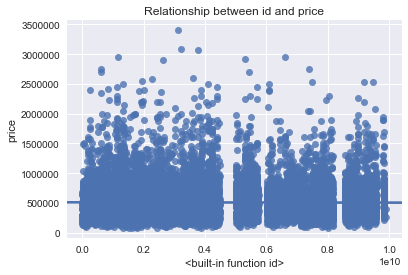

In [12]:
sns.regplot(x = df['id'], y = df['price'], data = data) 
plt.title('Relationship between id and price')
plt.xlabel(id)
plt.show()

The id has no influence on price therefore we're going to drop the column.

In [13]:
df.drop(['id'], axis = 1, inplace=True)

# data column

Create a column that will only keep the year.

In [14]:
df['year'] = pd.DatetimeIndex(df['date']).year
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year
0,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,...,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,2014
1,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,...,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,2014
2,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,...,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062,2015
3,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,...,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,2014
4,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,...,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,2015


In [15]:
#delete date column
df.drop(['date'], axis = 1, inplace = True)

In [16]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year
0,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,2014
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,2014
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062,2015
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,2014
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,2015


In [17]:
df['year'].describe()

count    20594.000000
mean      2014.323347
std          0.467765
min       2014.000000
25%       2014.000000
50%       2014.000000
75%       2015.000000
max       2015.000000
Name: year, dtype: float64

In [18]:
df['year'].unique()

array([2014, 2015])

Lets see if the year the sale took place has any influence on the price.

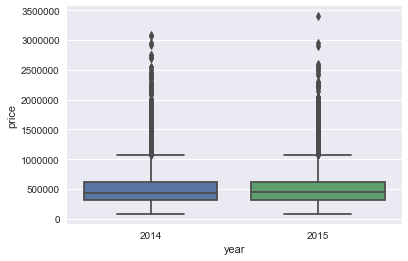

In [19]:
sns.boxplot(x='year',y='price',data=df)

# sqft_living column

In [20]:
df['sqft_living'].describe()

count    20594.000000
mean      1997.114159
std        777.774193
min        370.000000
25%       1410.000000
50%       1880.000000
75%       2470.000000
max       4800.000000
Name: sqft_living, dtype: float64

Check for outliers.

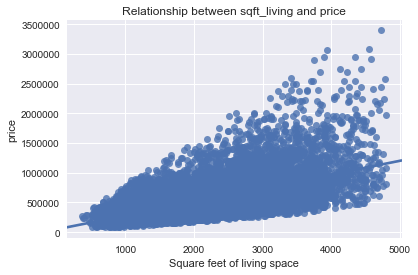

In [21]:
sns.regplot(x = df['sqft_living'], y = df['price'], data = data) 
plt.title('Relationship between sqft_living and price')
plt.xlabel('Square feet of living space')
plt.show()

We can see that the price increases when the living space incrteases. 

# sqft_lot column

In [22]:
df['sqft_lot'].describe()

count     20594.000000
mean      10536.712829
std       13169.252192
min         520.000000
25%        5000.000000
50%        7480.000000
75%       10137.000000
max      134489.000000
Name: sqft_lot, dtype: float64

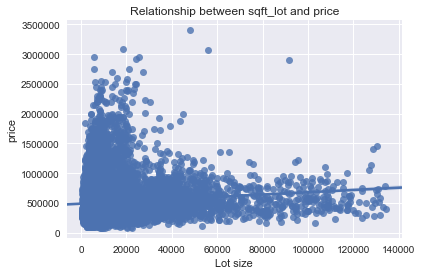

In [23]:
sns.regplot(x = df['sqft_lot'], y = df['price'], data = data) 
plt.title('Relationship between sqft_lot and price')
plt.xlabel('Lot size')
plt.show()

# sqft_above column

In [24]:
df['sqft_above'].describe()

count    20594.000000
mean      1716.672186
std        718.181427
min        370.000000
25%       1180.000000
50%       1530.000000
75%       2120.000000
max       4800.000000
Name: sqft_above, dtype: float64

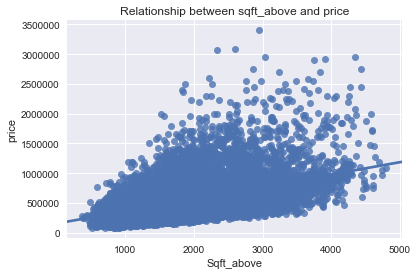

In [25]:
sns.regplot(x = df['sqft_above'], y = df['price'], data = data) 
plt.title('Relationship between sqft_above and price')
plt.xlabel('Sqft_above')
plt.show()

## sqft_basement column

In [26]:
df['sqft_basement'].describe()

count     20594
unique      264
top         0.0
freq      12248
Name: sqft_basement, dtype: object

In [27]:
df['sqft_basement'].value_counts()

0.0       12248
?           434
600.0       212
700.0       207
500.0       205
          ...  
1008.0        1
518.0         1
602.0         1
20.0          1
2050.0        1
Name: sqft_basement, Length: 264, dtype: int64

We have 454 missing values for basement. We'll replace these values with 0.

In [28]:
df.loc[(data['sqft_basement'] == '?')] = 0

In [29]:
#Transform value type from object to number.
df['sqft_basement'] = pd.to_numeric(df['sqft_basement'],errors='coerce')

In [30]:
def basement(df):
    '''creates bool feature has_basement and drops original basement feature'''
    df['basement'] = np.where(df['sqft_basement']>0, 1 , 0)
    df = df.drop('sqft_basement', axis = 1, inplace = True)
    return df

In [31]:
basement(df)

In [32]:
df['basement'].value_counts()

0    12682
1     7912
Name: basement, dtype: int64

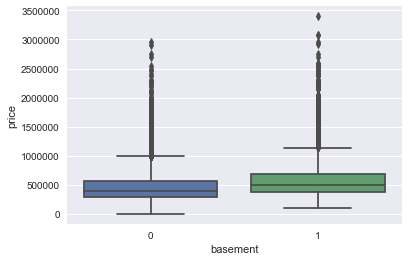

In [33]:
import seaborn as sns
%matplotlib inline
sns.boxplot(x='basement',y='price',data=df)

There is a slight increase in price when the house has a basement, and it's probably related to having a larger sqft_living area.

# yr_built column

In [34]:
df['yr_built'].describe()

count    20594.000000
mean      1928.924444
std        284.508593
min          0.000000
25%       1950.000000
50%       1972.000000
75%       1995.000000
max       2015.000000
Name: yr_built, dtype: float64

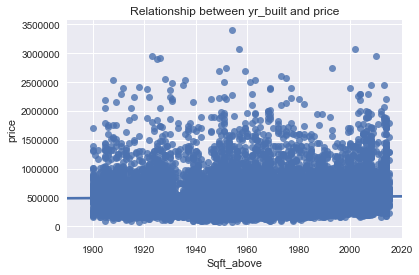

In [35]:
sns.regplot(x = df['yr_built'], y = df['price'], data = df) 
plt.title('Relationship between yr_built and price')
plt.xlabel('Sqft_above')
plt.xlim(1890,2020)
plt.show()

# lat column

In [36]:
df['lat'].describe()

count    20594.000000
mean        46.558137
std          6.832718
min          0.000000
25%         47.457100
50%         47.568400
75%         47.677700
max         47.777600
Name: lat, dtype: float64

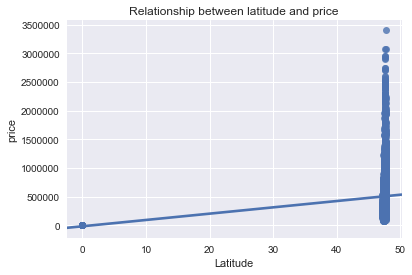

In [37]:
sns.regplot(x = df['lat'], y = df['price'], data = df) 
plt.title('Relationship between latitude and price')
plt.xlabel('Latitude')

plt.show()

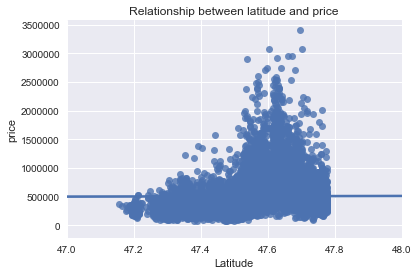

In [38]:
sns.regplot(x = df['lat'], y = df['price'], data = df) 
plt.title('Relationship between latitude and price')
plt.xlabel('Latitude')
plt.xlim(47,48)
plt.show()


In [39]:
df['lat'].value_counts()

0.0000     434
47.5322     17
47.6846     16
47.6886     16
47.6711     16
          ... 
47.3310      1
47.3866      1
47.4152      1
47.4548      1
47.2715      1
Name: lat, Length: 4958, dtype: int64

We have 434 houses on Latitude, which means missing information. I don't see a relation between latitude and price we'll keep these rows but we will delete the whole lat column.

In [40]:
df.drop(['lat'], axis = 1, inplace = True)

# long column

In [41]:
df['long'].describe()

count    20594.000000
mean      -119.642603
std         17.555338
min       -122.512000
25%       -122.329000
50%       -122.231000
75%       -122.124000
max          0.000000
Name: long, dtype: float64

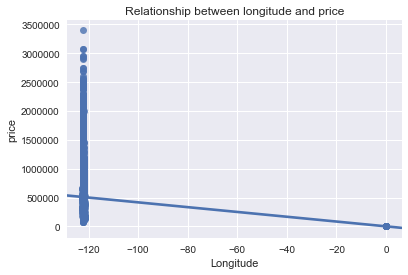

In [42]:
sns.regplot(x = df['long'], y = df['price'], data = df) 
plt.title('Relationship between longitude and price')
plt.xlabel('Longitude')
plt.show()

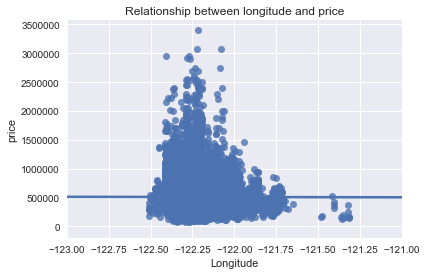

In [43]:
sns.regplot(x = df['long'], y = df['price'], data = df) 
plt.title('Relationship between longitude and price')
plt.xlabel('Longitude')
plt.xlim(-123,-121)
plt.show()

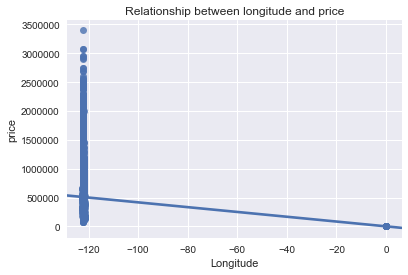

In [44]:
sns.regplot(x = df['long'], y = df['price'], data = df) 
plt.title('Relationship between longitude and price')
plt.xlabel('Longitude')
plt.show()

In [45]:
df['long'].value_counts()

 0.000      434
-122.290    109
-122.300    108
-122.362    100
-122.291     95
           ... 
-121.950      1
-122.467      1
-121.845      1
-121.785      1
-121.316      1
Name: long, Length: 716, dtype: int64

We have 434 houses on  0 Longitude, which means missing information. I don't see a relation between longitude and price we'll keep these rows but we will delete the whole long column.

In [46]:
df.drop(['long'], axis = 1, inplace = True)

# sqft_living15 column

In [47]:
df['sqft_living15'].describe()

count    20594.000000
mean      1897.086287
std        677.301051
min          0.000000
25%       1450.000000
50%       1800.000000
75%       2290.000000
max       5790.000000
Name: sqft_living15, dtype: float64

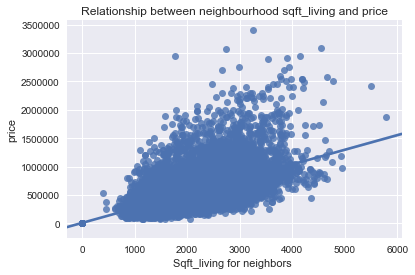

In [48]:
sns.regplot(x = df['sqft_living15'], y = df['price'], data = df) 
plt.title('Relationship between neighbourhood sqft_living and price')
plt.xlabel('Sqft_living for neighbors ')
plt.show()

# sqft_lot15 column

In [49]:
df['sqft_lot15'].describe()

count     20594.000000
mean       9994.911431
std       15510.075588
min           0.000000
25%        5000.000000
50%        7455.000000
75%        9713.750000
max      434728.000000
Name: sqft_lot15, dtype: float64

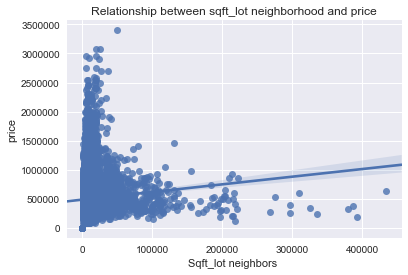

In [50]:
sns.regplot(x = df['sqft_lot15'], y = df['price'], data = df) 
plt.title('Relationship between sqft_lot neighborhood and price')
plt.xlabel('Sqft_lot neighbors ')
plt.show()

We're done with the columns with large numbers of unique values. Now we're going to check the columns with low numbers of unique valuyes.

# bedrooms column

In [51]:
df['bedrooms'].describe()

count    20594.000000
mean         3.269496
std          0.978581
min          0.000000
25%          3.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: bedrooms, dtype: float64

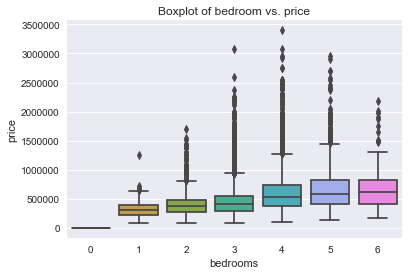

In [52]:

sns.boxplot(x = df['bedrooms'], y = df['price'])
plt.title("Boxplot of bedroom vs. price")
plt.ylabel("price")
plt.xlabel("bedrooms")
plt.show()

# bathrooms column

In [53]:
df['bathrooms'].describe()

count    20594.000000
mean         2.025687
std          0.765182
min          0.000000
25%          1.500000
50%          2.000000
75%          2.500000
max          5.250000
Name: bathrooms, dtype: float64

Since we can see that there are some houses without a bath we need to investigate further.

In [54]:
df['bathrooms'].value_counts()

2.50    5086
1.00    3697
1.75    2939
2.25    1983
2.00    1848
1.50    1403
2.75    1116
3.00     681
3.50     584
3.25     471
0.00     434
3.75     108
4.00      79
0.75      56
4.50      51
4.25      34
1.25       8
5.00       6
4.75       5
0.50       3
5.25       2
Name: bathrooms, dtype: int64

Again we have 434 houses with 0 bathrooms. We had 434 0values for lat and long. Let's see how those rows look like.

In [55]:
df[df['bathrooms']==0]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,year,basement
6,0.0,0,0.0,0,0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0,0,0
18,0.0,0,0.0,0,0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0,0,0
42,0.0,0,0.0,0,0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0,0,0
79,0.0,0,0.0,0,0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0,0,0
112,0.0,0,0.0,0,0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21442,0.0,0,0.0,0,0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0,0,0
21447,0.0,0,0.0,0,0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0,0,0
21473,0.0,0,0.0,0,0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0,0,0
21519,0.0,0,0.0,0,0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0,0,0


We have 434 rows with no information on it. Let's go ahead and delete those rows.

In [56]:
len(df)

20594

In [57]:
df1= df[df.bathrooms > 0]

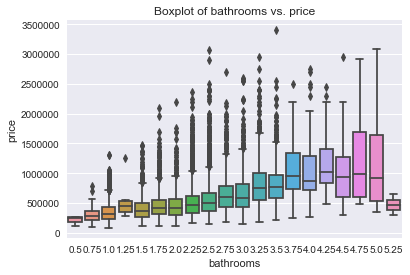

In [58]:
sns.boxplot(x = df1['bathrooms'], y = df1['price'])
plt.title("Boxplot of bathrooms vs. price")
plt.ylabel("price")
plt.xlabel("bathrooms")
plt.show()

# floors column

In [59]:
df1['floors'].describe()

count    20160.000000
mean         1.480878
std          0.538506
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          3.500000
Name: floors, dtype: float64

In [60]:
df1['bathrooms'].value_counts()

2.50    5086
1.00    3697
1.75    2939
2.25    1983
2.00    1848
1.50    1403
2.75    1116
3.00     681
3.50     584
3.25     471
3.75     108
4.00      79
0.75      56
4.50      51
4.25      34
1.25       8
5.00       6
4.75       5
0.50       3
5.25       2
Name: bathrooms, dtype: int64

In [61]:
df1['bathrooms'].unique()

array([1.  , 2.25, 3.  , 2.  , 1.5 , 2.5 , 1.75, 2.75, 3.25, 4.  , 3.5 ,
       0.75, 5.  , 4.5 , 4.25, 3.75, 1.25, 4.75, 0.5 , 5.25])

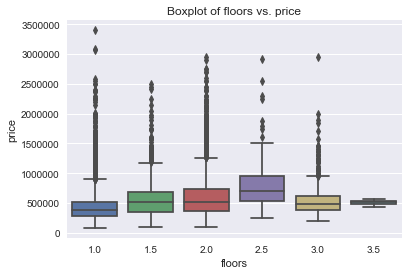

In [62]:
sns.boxplot(x = df1['floors'], y = df1['price'])
plt.title("Boxplot of floors vs. price")
plt.ylabel("price")
plt.xlabel("floors")
plt.show()

# waterfront column

In [63]:
df1['waterfront'].describe()

count    17922.000000
mean         0.005859
std          0.076320
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: waterfront, dtype: float64

In [64]:
df1['waterfront'].unique()

array([nan,  0.,  1.])

We have a few nan values in waterfront column, we're going to replace them with 0.

In [65]:
df1['waterfront'].fillna(0, inplace=True)

In [66]:
df1['waterfront'].unique()

array([0., 1.])

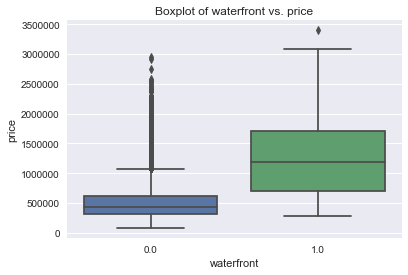

In [67]:
sns.boxplot(x = df1['waterfront'], y = df1['price'])
plt.title("Boxplot of waterfront vs. price")
plt.ylabel("price")
plt.xlabel("waterfront")
plt.show()

# view column

In [68]:
df1['view'].describe()

count    20104.000000
mean         0.203442
std          0.711050
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: view, dtype: float64

In [69]:
df1['view'].unique()

array([ 0., nan,  3.,  4.,  2.,  1.])

Let's turn nan values into 0s.

In [70]:
df1['view'].fillna(0, inplace=True)

In [71]:
df1['view'].unique()

array([0., 3., 4., 2., 1.])

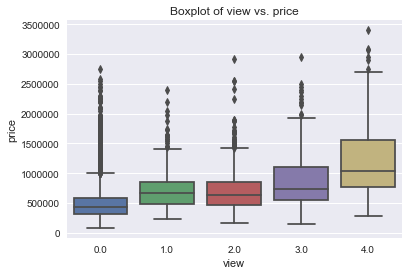

In [72]:
sns.boxplot(x = df1['view'], y = df1['price'])
plt.title("Boxplot of view vs. price")
plt.ylabel("price")
plt.xlabel("view")
plt.show()

# condition column

In [73]:
df1['condition'].describe()

count    20160.000000
mean         3.420437
std          0.647676
min          2.000000
25%          3.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: condition, dtype: float64

In [74]:
df1['condition'].unique()

array([3, 5, 4, 2])

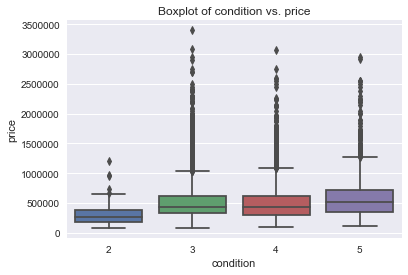

In [75]:
sns.boxplot(x = df1['condition'], y = df1['price'])
plt.title("Boxplot of condition vs. price")
plt.ylabel("price")
plt.xlabel("condition")
plt.show()

# grade column

In [76]:
df1['grade'].describe()

count    20160.000000
mean         7.564187
std          1.025034
min          5.000000
25%          7.000000
50%          7.000000
75%          8.000000
max         10.000000
Name: grade, dtype: float64

In [77]:
df1['grade'].unique()

array([ 7,  6,  8,  9, 10,  5])

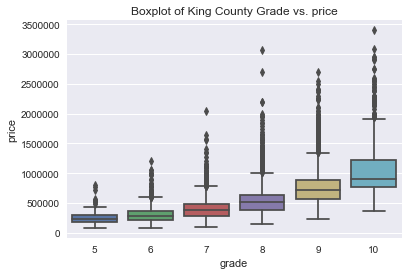

In [78]:
sns.boxplot(x = df1['grade'], y = df1['price'])
plt.title("Boxplot of King County Grade vs. price")
plt.ylabel("price")
plt.xlabel("grade")
plt.show()

# yr_renovated column

In [79]:
df['yr_renovated'].describe()

count    17008.000000
mean        80.155868
std        391.902743
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       2015.000000
Name: yr_renovated, dtype: float64

In [80]:
df1['yr_renovated'].unique()

array([   0., 1991.,   nan, 2002., 2010., 1992., 2013., 1994., 1978.,
       2005., 2003., 1984., 1954., 2014., 2011., 1983., 1945., 1990.,
       1988., 1977., 1981., 1995., 2000., 1999., 1998., 1970., 1989.,
       2004., 1986., 2007., 1987., 2006., 1985., 1980., 1971., 1979.,
       1997., 1950., 1969., 1948., 2009., 2015., 1974., 2008., 1968.,
       2012., 1963., 1951., 1962., 1953., 1993., 1955., 1996., 2001.,
       1982., 1956., 1940., 1976., 1975., 1964., 1973., 1957., 1959.,
       1960., 1967., 1965., 1934., 1972., 1944., 1958.])

In [81]:
df1['yr_renovated'].fillna(0, inplace=True)

In [82]:
 df1['renovated'] = df1['yr_renovated'].map(lambda x: 1 if x > 0 else 0)

In [83]:
df1.drop(['yr_renovated'], axis = 1, inplace = True )

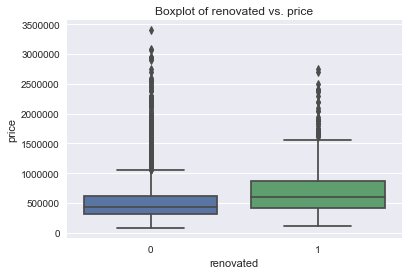

In [84]:
sns.boxplot(x = df1['renovated'], y = df1['price'])
plt.title("Boxplot of renovated vs. price")
plt.ylabel("price")
plt.xlabel("renovated")
plt.show()

# zipcode colum

In [85]:
df1['zipcode'].describe()

count    20160.000000
mean     98079.021925
std         53.717063
min      98001.000000
25%      98033.000000
50%      98070.000000
75%      98118.000000
max      98199.000000
Name: zipcode, dtype: float64

In [86]:
df1['zipcode'].unique()

array([98178, 98125, 98028, 98136, 98074, 98198, 98146, 98038, 98007,
       98115, 98107, 98126, 98019, 98103, 98003, 98133, 98040, 98092,
       98030, 98002, 98119, 98112, 98052, 98027, 98117, 98058, 98001,
       98056, 98166, 98023, 98070, 98148, 98105, 98042, 98008, 98059,
       98122, 98144, 98004, 98034, 98075, 98116, 98118, 98199, 98032,
       98045, 98102, 98077, 98108, 98168, 98177, 98065, 98029, 98006,
       98109, 98022, 98033, 98155, 98024, 98011, 98053, 98031, 98010,
       98106, 98072, 98188, 98005, 98055, 98014, 98039])

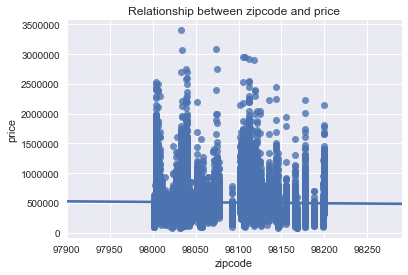

In [87]:
sns.regplot(x = df1['zipcode'], y = df1['price'], data = df1) 
plt.title('Relationship between zipcode and price')
plt.xlabel('zipcode')
plt.xlim(97900, 98290)
plt.show()

Check for missing data.

In [88]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20160 entries, 0 to 21596
Data columns (total 18 columns):
price            20160 non-null float64
bedrooms         20160 non-null int64
bathrooms        20160 non-null float64
sqft_living      20160 non-null int64
sqft_lot         20160 non-null int64
floors           20160 non-null float64
waterfront       20160 non-null float64
view             20160 non-null float64
condition        20160 non-null int64
grade            20160 non-null int64
sqft_above       20160 non-null int64
yr_built         20160 non-null int64
zipcode          20160 non-null int64
sqft_living15    20160 non-null int64
sqft_lot15       20160 non-null int64
year             20160 non-null int64
basement         20160 non-null int64
renovated        20160 non-null int64
dtypes: float64(5), int64(13)
memory usage: 3.5 MB


# Question 1
Is it worth renovating your house before you sell it. Will the renovation increase the price?

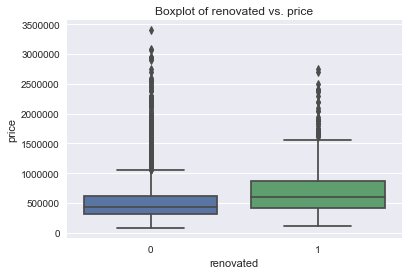

In [93]:
sns.boxplot(x = df1['renovated'], y = df1['price'])
plt.title("Boxplot of renovated vs. price")
plt.ylabel("price")
plt.xlabel("renovated")
plt.show()

In [101]:
renovatedmean = df1[df1['renovated'] == 1]['price'].mean()
nonrenovatedmean = df1[df1['renovated'] == 0]['price'].mean()
print(f"The mean house price for a renovated house  is USD {round(renovatedmean,2)}")
print(f"The mean house price for a house without renovation view is USD {round(nonrenovatedmean,2)}")
renovated_price_increase = round((renovatedmean-nonrenovatedmean)*100/nonrenovatedmean , 2)
print(f"The mean house price of a renovated house increases with {renovated_price_increase}percent.")


The mean house price for a renovated house  is USD 709570.96
The mean house price for a house without renovation view is USD 501297.95
The mean house price of a renovated house increases with 41.55percent.


# 1st conclusion:
It's worh renovating the house since there is a big chance that it will increase the value of the house with 41.55%.


# Question 2
Does the King County assigned grade makes any difference in price?

# Question 3
What are the most popular zipcodes?

In [112]:
df_zipcode_2014 = df1[df1['year']==2014]
df_zipcode_2015 = df1[df1['year']==2015]

In [123]:
df_zipcode_2014['dummy']=np.ones(len(df_zipcode_2014))


In [127]:
df_zipcode_2014.groupby('zipcode')['dummy'].sum().sort_values(ascending=False)

zipcode
98103    417.0
98052    394.0
98115    384.0
98117    382.0
98034    371.0
         ...  
98014     62.0
98010     51.0
98148     37.0
98024     34.0
98039     23.0
Name: dummy, Length: 70, dtype: float64

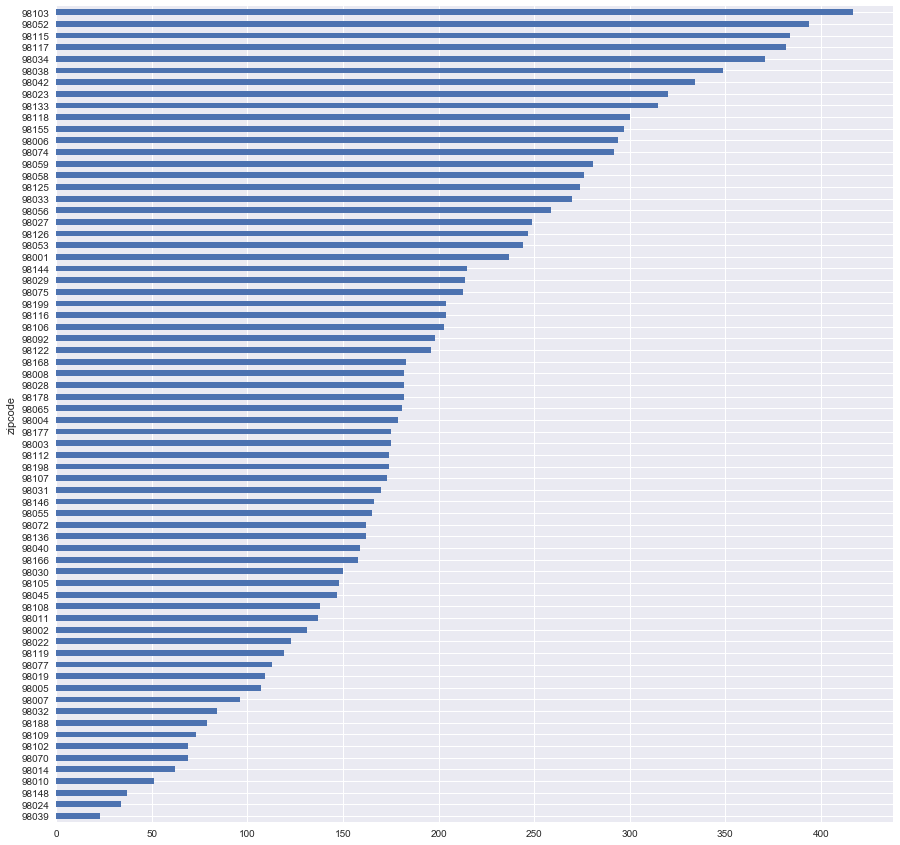

In [134]:
df_zipcode_2014.groupby('zipcode')['dummy'].sum().sort_values(ascending=True).plot(kind='barh', figsize=(15,15))

In [129]:
df_zipcode_2015['dummy']=np.ones(len(df_zipcode_2015))

In [130]:
df_zipcode_2015.groupby('zipcode')['dummy'].sum().sort_values(ascending=False)

zipcode
98042    193.0
98038    193.0
98118    192.0
98115    182.0
98103    166.0
         ...  
98102     23.0
98070     22.0
98024     20.0
98148     16.0
98039     10.0
Name: dummy, Length: 70, dtype: float64

In [ ]:
df_zipcodes_2014.value_counts(self, normalize=False, sort=True, ascending=False, bins=None, dropna=True)

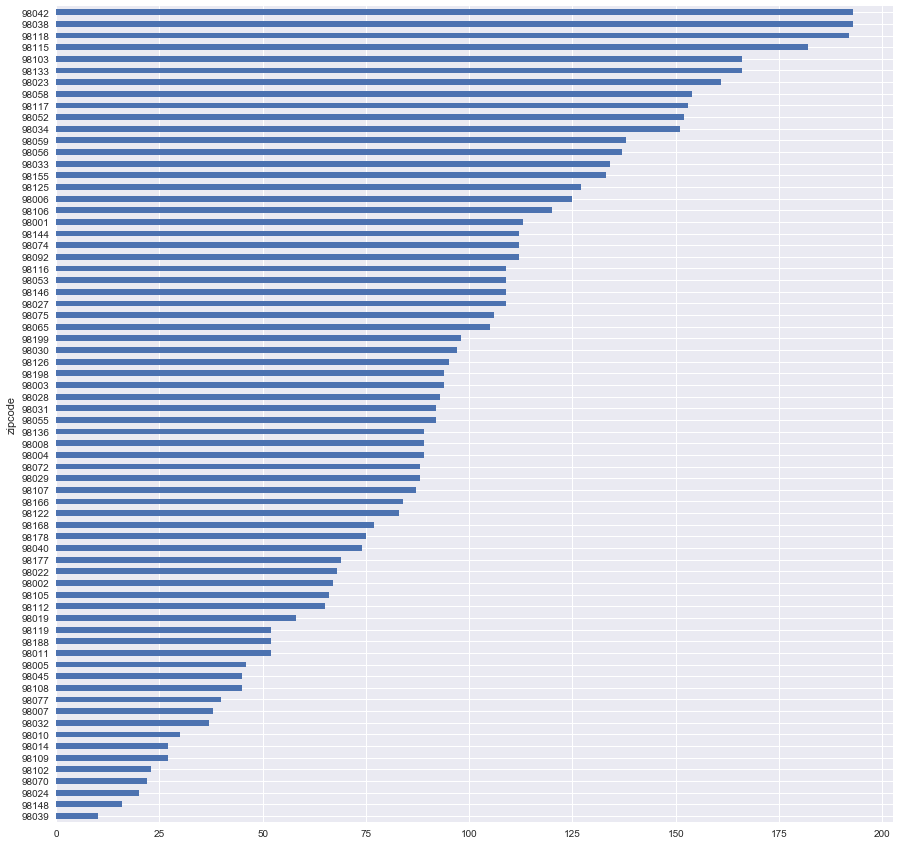

In [135]:
df_zipcode_2015.groupby('zipcode')['dummy'].sum().sort_values(ascending=True).plot(kind='barh', figsize=(15,15))

# Set zipcode type to string (folium)
df1['zipcode'] = df1['zipcode'].astype('str')
# get the mean value across all data points
zipcode_data = df1.groupby('zipcode').aggregate(np.mean)
zipcode_data.reset_index(inplace = True)

# count number of houses grouped by zipcode
df1['count'] = 1
temp = df1.groupby('zipcode').sum()
temp.reset_index(inplace = True)
temp = temp[['zipcode', 'count']]
zipcode_data = pd.merge(zipcode_data, temp, on='zipcode')
# drop count from org dataset
df1.drop(['count'], axis = 1, inplace = True)

# Get geo data file path
import os
geo_data_file = 'Zipcodes_for_King_County.geojson' 
# load GeoJSON
with open(geo_data_file, 'r') as jsonFile:
    geo_data = json.load(jsonFile)
    
tmp = geo_data
# remove ZIP codes not in geo data
geozips = []
for i in range(len(tmp['features'])):
    if tmp['features'][i]['properties']['ZIPCODE'] in list(zipcode_data['zipcode'].unique()):
        geozips.append(tmp['features'][i])
# creating new JSON object
new_json = dict.fromkeys(['type','features'])
new_json['type'] = 'FeatureCollection'
new_json['features'] = geozips
# save uodated JSON object
open("cleaned_geodata.json", "w").write(json.dumps(new_json, sort_keys=True, indent=4, separators=(',', ': ')))

In [156]:
import folium 
from folium import plugins
from folium.plugins import HeatMap

def map_feature_by_zipcode(zipcode_data, col):
    """
    Generates a folium map of Seattle
    :param zipcode_data: zipcode dataset
    :param col: feature to display
    :return: m
    """

    # read updated geo data
    king_geo = "cleaned_geodata.json"

    # Initialize Folium Map with Seattle latitude and longitude
    m = folium.Map(location=[47.35, -121.9], zoom_start=9,
                   detect_retina=True, control_scale=False)

    # Create choropleth map
    m.choropleth(
        geo_data=king_geo,
        name='choropleth',
        data=zipcode_data,
        # col: feature of interest
        columns=['zipcode', col],
        key_on='feature.properties.ZIPCODE',
        fill_color='OrRd',
        fill_opacity=0.9,
        line_opacity=0.2,
        legend_name='house ' + col
    )

    folium.LayerControl().add_to(m)

    # Save map based on feature of interest
    m.save(col + '.html')

    return m

map_feature_by_zipcode(zipcode_data, 'count')

# Train test

In [158]:
from sklearn.model_selection import train_test_split

In [159]:
X = df1.drop('price', axis = 1)
y = df1['price']

In [160]:
# Train-test split (10% to test set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [161]:
# A brief preview of train-test split
print(len(X_train), len(X_test), len(y_train), len(y_test))

18144 2016 18144 2016


In [162]:
data_1_t = pd.concat([X_train, y_train], axis = 1)
data_1_t.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,zipcode,sqft_living15,sqft_lot15,year,basement,renovated,price
15867,3,1.75,1740,8560,1.0,0.0,0.0,3,8,1500,1948,98199,2240,5800,2014,1,0,827235.0
1907,3,1.75,2250,26337,1.0,0.0,0.0,3,8,2250,1980,98092,1830,26337,2014,0,0,325000.0
8383,3,2.25,1520,1221,3.0,0.0,0.0,3,8,1520,2013,98107,1550,4750,2014,0,0,565000.0
10326,4,2.50,2600,9355,1.0,0.0,0.0,3,9,1840,1983,98028,2250,7691,2014,1,0,509000.0
3843,3,2.00,1430,9250,1.0,0.0,0.0,4,8,990,1983,98052,1830,8003,2015,1,0,510000.0


# Let's see what atributes increase the price of the house.

Square feet of living space.

In [ ]:

sns.boxplot(x = data_1_t['sqft_living'], y = data_1_t['price'])
plt.title("Boxplot of sqft_living vs. price")
plt.ylabel("price in USD")
plt.xlabel("grade")
plt.show()

For an initial idea on how the predictors relate, you can take a look at scatterplots between predictors.

In [ ]:
pd.plotting.scatter_matrix(data_1, figsize=[18,18]);
plt.show

# Check for correlations.

In [ ]:
# Use .corr to see how our values correlate.
data_1.corr()

In [ ]:
#Check to find correlations bigger than 0.75.
abs(data_1.corr()) > 0.75

In [ ]:
df=data_1.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
df['pairs'] = list(zip(df.level_0, df.level_1))

# set index to pairs
df.set_index(['pairs'], inplace = True)

#drop level columns
df.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
df.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
df.drop_duplicates(inplace=True)

In [ ]:
# Since a correlation of 1 happens only when data is identical we onlky need to separate correlation smaller than 1 and larger than 0.75.
df[(df.cc>.75) & (df.cc <1)]

In [ ]:
#Plot correlations in a heatmap.
fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(data_t_1, cmap="YlGnBu", annot=True);

We will drop: 'sqft_above', 'sqft_living15', 'bathrooms', 'sqft_lot15', 'floors', 'sqft_basement','lat', 'long','yr_built' to avoid correlations.

In [ ]:
data_1.drop(['sqft_above', 'sqft_living15', 'bathrooms', 'sqft_lot15', 'floors', 'sqft_basement','lat', 'long','yr_built'], axis=1, inplace = True)

In [ ]:
#Check again for correlations after we dropped.
import seaborn as sns
sns.heatmap(data_1.corr(), center=0);

In [ ]:
df=data_1.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
df['pairs'] = list(zip(df.level_0, df.level_1))

# set index to pairs
df.set_index(['pairs'], inplace = True)

#drop level columns
df.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
df.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
df.drop_duplicates(inplace=True)

In [ ]:
df[(df.cc>.75) & (df.cc <1)]

Yay! No corelations.

# Deal with categorical data.

We have 2 columns with categorical data: 'waterfront', and 'renovated'.

In [ ]:
plt.scatter(data_1['waterfront'], data_1['price'])
plt.title('waterfront')
plt.show()

In [ ]:
plt.scatter(data_1['renovated'], data_1['price'])
plt.title('renovated')
plt.show()

# Q1 - Is it worth renovating the house you're thinking of selling?

In [ ]:
import seaborn as sns
%matplotlib inline
sns.boxplot(x='renovated',y='price',data=df)

As you can see the price of the house seems to be higher when the house is renovated.

# Q2 - Are houses with waterfront more expensive?

In [ ]:
import seaborn as sns
%matplotlib inline
sns.boxplot(x='waterfront',y='price',data=df)

In [ ]:

waterfrontmean = df[df['waterfront'] == 1]['price'].mean()
nonwaterfrontmean = df[df['waterfront'] == 0]['price'].mean()
print(f"The mean house price for a house with waterfront view is USD {round(waterfrontmean,2)}")
print(f"The mean house price for a house without waterfront view is USD {round(nonwaterfrontmean,2)}")

It's pretty obvious that houses with waterfront are more expensive.

Q3 Does the grade affects the price in any way?

Building grade is a feature from King County government and represents the construction quality of improvements. 
1-3 Falls short of minimum building standards. Normally cabin or inferior structure.
4 Generally older, low quality construction. Does not meet code.
5 Low construction costs and workmanship. Small, simple design.
6 Lowest grade currently meeting building code. Low quality materials and simple designs.
7 Average grade of construction and design. Commonly seen in plats and older sub-divisions.
8 Just above average in construction and design. Usually better materials in both the exterior and interior finish work.
9 Better architectural design with extra interior and exterior design and quality.
10 Homes of this quality generally have high quality features. Finish work is better and more design quality is seen in the floor plans. Generally have a larger square footage.
11 Custom design and higher quality finish work with added amenities of solid woods, bathroom fixtures and more luxurious options.
12 Custom design and excellent builders. All materials are of the highest quality and all conveniences are present.
13 Generally custom designed and built. Mansion level. Large amount of highest quality cabinet work, wood trim, marble, entry ways etc.

In [ ]:
# Plot grade distribution
df['grade'].hist()
plt.title('Distribution of building grade feature')
plt.xlabel('Grade')
plt.show()

In [ ]:
sns.boxplot(x = df['grade'], y = df['price'])
plt.title("Boxplot of grade vs. price")
plt.ylabel("price in USD")
plt.xlabel("grade")
plt.show()

In [ ]:
ax = sns.catplot(x='sqft_living', y="price", hue = 'grade', data=df);

In [ ]:
ax = sns.catplot(x='sqft_lot', y="price", hue = 'grade', data=df);

Train - test

Before proceeding further, we wish to split our data into a training set and a testing set. We will first need to seperate features from target and then we will make use of sklearn's train_test_split() function. We will choose to keep 10% of our data for final testing of our model.

In [ ]:
# Split features X and target y
X = kcdata.drop('price', axis = 1)
y = kcdata['price']

In [ ]:
from statsmodels.formula.api import ols

In [ ]:
outcome = 'price'
x_cols = ['displacement', 'horsepower', 'weight', 'acceleration']
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=data).fit()
model.summary()